In [29]:
import data_handling
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np

In [30]:
#torch.set_default_dtype(torch.float16)
DATASET_DIRECTORY = "./CelebDataProcessed"
ANNOTATIONS_DIRECTORY = "./annotations.csv"
NAME = "Donald Trump"

BATCH_SIZE = 256

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

pubfig = data_handling.PublicFigureDataset(ANNOTATIONS_DIRECTORY, DATASET_DIRECTORY, NAME)#, transform=torchvision.transforms.ToTensor())

train_size = int(0.8 * len(pubfig))
test_size = len(pubfig) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(pubfig, [train_size, test_size])

In [32]:
index = 0
print(type(pubfig[index][0]))
print((pubfig[index][0].size())) # Image
print((pubfig[index][1])) # Label

<class 'torch.Tensor'>
torch.Size([3, 256, 256])
Donald Trump


In [33]:
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Feature batch shape: torch.Size([62, 3, 256, 256])


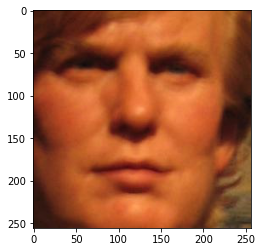

Label: Donald Trump


In [34]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")

img = train_features[0].squeeze()

label = train_labels[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")

In [35]:
def train_epoch(model, device, dataloader, loss_fn, optimizer, default_dtype):
    # Set train mode for both the encoder and the decoder
    model.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.type(default_dtype).to(device)

        # Encode data
        output = model(image_batch)
        #print((model.encode(image_batch)).size())
        #print(model.decode(model.encode(image_batch)).size())

        # Evaluate loss
        loss = loss_fn(output, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

def test_epoch(model, device, dataloader, loss_fn, default_dtype=torch.FloatTensor):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.type(default_dtype).to(device)#image_batch.type(torch.HalfTensor).to(device)
            # Encode data
            output = model(image_batch)

            # Append the network output and the original image to the lists
            conc_out.append(output.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [36]:
def saveWeights(model, path):
    torch.save(model.state_dict(), path) # model.state_dict(), 'model_weights.pth')

def loadWeights(model, path):
    model.load_state_dict(torch.load(path)) # 'model_weights.pth'))
    model.eval()

In [37]:
import time

def train_epoch(model, device, trainloader, loss_fn, optimizer, testloader, epochs=5, default_dtype=torch.FloatTensor):

    start_time = time.time()
    iters = 0
    running_loss = 0.0

    # Set train mode for both the encoder and the decoder
    model.train()
    train_loss = []
    for ep in range(epochs):
        # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
        for i, (image_batch, _) in enumerate(trainloader): # with "_" we just ignore the labels (the second element of the dataloader tuple)
            iters += 1

            # Move tensor to the proper device
            image_batch = image_batch.type(default_dtype).to(device)
            #labels = labels.type(default_dtype).to(device)

            # Encode data
            output = model(image_batch)

            # Evaluate loss
            loss = loss_fn(output, image_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
            if i % 1 == 0:
                print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, i, time_lapse, loss.data, running_loss/iters))

            # Print batch loss
            train_loss.append(loss.detach().cpu().numpy())
        test_loss = test_epoch(model, device, testloader, loss_fn)
        print('\n EPOCH {}/{} \t Train loss {} \t Test loss {}'.format(ep + 1, epochs, np.mean(train_loss), test_loss))
        train_loss = [] # clear train_loss
    #saveWeights(model, "5EpochsBatchNorm3D.pth")
    return



def test_epoch(model, device, dataloader, loss_fn, default_dtype=torch.FloatTensor):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.type(default_dtype).to(device)#image_batch.type(torch.HalfTensor).to(device)
            # Encode data
            output = model(image_batch)

            # Append the network output and the original image to the lists
            conc_out.append(output.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [38]:
import models
import e

model = models.AutoEncoder(3, 100, batch_norm=False,stride_dim=2, flat_start=1, dropout_odds=.5).to(device)
#model = e.AutoEncoder(100).to(device)
#loadWeights(model, "./CPU1.pth")

print(len(train_features[0][1]))
img = train_features[0]
#img = np.float32(train_features[0])
#arr = torchvision.transform.ToTensor(img)
#model.forward(img.to(torch.device('cuda')))

loss_fn = torch.nn.MSELoss()
lr= 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)
print(model)

256
AutoEncoder(
  (encoder): Encoder(
    (model): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
        (1): ReLU()
        (2): Dropout2d(p=0.5, inplace=False)
        (3): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
        (4): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
        (1): ReLU()
        (2): Dropout2d(p=0.5, inplace=False)
        (3): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
        (4): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
        (1): ReLU()
        (2): Dropout2d(p=0.5, inplace=False)
        (3): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
        (4): ReLU()
      )
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=576, out_features=144, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=14

In [39]:
#print(model)
#model.eval()
#print(len(model.encode(img.type(torch.FloatTensor))))

In [40]:
train_epoch(model,device, train_dl,loss_fn,optim, testloader=test_dl, epochs=10)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 20832.4609 | Average Loss: 20832.4609 

 EPOCH 1/10 	 Train loss 20832.4609375 	 Test loss 20631.490234375
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 20831.8164 | Average Loss: 20832.1387 

 EPOCH 2/10 	 Train loss 20831.81640625 	 Test loss 20631.068359375
Epoch: 3 | Iter:    0 | Time: 00:00:02 | Train Loss: 20831.4004 | Average Loss: 20831.8926 

 EPOCH 3/10 	 Train loss 20831.400390625 	 Test loss 20630.642578125
Epoch: 4 | Iter:    0 | Time: 00:00:03 | Train Loss: 20830.9727 | Average Loss: 20831.6626 

 EPOCH 4/10 	 Train loss 20830.97265625 	 Test loss 20630.197265625
Epoch: 5 | Iter:    0 | Time: 00:00:04 | Train Loss: 20830.5332 | Average Loss: 20831.4367 

 EPOCH 5/10 	 Train loss 20830.533203125 	 Test loss 20629.712890625
Epoch: 6 | Iter:    0 | Time: 00:00:04 | Train Loss: 20830.0547 | Average Loss: 20831.2064 

 EPOCH 6/10 	 Train loss 20830.0546875 	 Test loss 20629.125
Epoch: 7 | Iter:    0 | Time: 00:00:05 |

In [41]:
saveWeights(model, "5EpochsBatchNorm.pth")

In [42]:
#num_epochs = 10
#diz_loss = {'train_loss':[],'val_loss':[]}
#for epoch in range(num_epochs):
#   train_loss =train_epoch(model,device, train_dl,loss_fn,optim, testloader=test_dl)
#   val_loss = test_epoch(model,device,test_dl,loss_fn)
#   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
#   diz_loss['train_loss'].append(train_loss)
#   diz_loss['val_loss'].append(val_loss)

In [53]:
#model2 = models.AutoEncoder(4, 200, batch_norm=True, flat_start=0, dropout_odds=.3).to(device)
#loadWeights(model2, "./CPU4.pth")
#train_epoch(model2,device, train_dl,loss_fn,optim, testloader=test_dl, epochs=5)

model2 = models.AutoEncoder(3, 100, batch_norm=False,stride_dim=2, flat_start=1, dropout_odds=.5).to(device)
loadWeights(model2, "./5EpochsBatchNorm3D.pth")
model2.eval()


AutoEncoder(
  (encoder): Encoder(
    (model): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
        (1): ReLU()
        (2): Dropout2d(p=0.5, inplace=False)
        (3): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
        (4): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
        (1): ReLU()
        (2): Dropout2d(p=0.5, inplace=False)
        (3): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
        (4): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
        (1): ReLU()
        (2): Dropout2d(p=0.5, inplace=False)
        (3): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
        (4): ReLU()
      )
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=576, out_features=144, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=144, o

In [54]:
train_epoch(model2,device, train_dl,loss_fn,optim, testloader=test_dl, epochs=10)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 86480.1641 | Average Loss: 86480.1641 

 EPOCH 1/10 	 Train loss 86480.1640625 	 Test loss 1624.6048583984375
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 1308.5194 | Average Loss: 43894.3417 

 EPOCH 2/10 	 Train loss 1308.5194091796875 	 Test loss 1624.6048583984375
Epoch: 3 | Iter:    0 | Time: 00:00:02 | Train Loss: 1308.5193 | Average Loss: 29699.0676 

 EPOCH 3/10 	 Train loss 1308.519287109375 	 Test loss 1624.6048583984375
Epoch: 4 | Iter:    0 | Time: 00:00:03 | Train Loss: 1308.5193 | Average Loss: 22601.4305 

 EPOCH 4/10 	 Train loss 1308.519287109375 	 Test loss 1624.6048583984375
Epoch: 5 | Iter:    0 | Time: 00:00:03 | Train Loss: 1308.5193 | Average Loss: 18342.8483 

 EPOCH 5/10 	 Train loss 1308.519287109375 	 Test loss 1624.6048583984375
Epoch: 6 | Iter:    0 | Time: 00:00:04 | Train Loss: 1308.5195 | Average Loss: 15503.7935 

 EPOCH 6/10 	 Train loss 1308.51953125 	 Test loss 1624.6048583984375
Epoch: 7 |

torch.Size([1, 3, 256, 256])


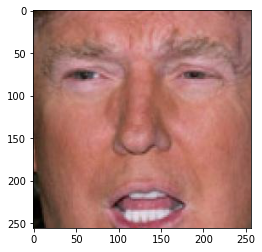

Label: Donald Trump


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x9 and 576x144)

In [69]:
model2.eval()

img = train_features[1].squeeze()
print(img.type(torch.FloatTensor)[None, :, :, :].size())
img2 = img.type(torch.FloatTensor)#[None, :, :, :].size()
#img2 = model2(img.type(torch.FloatTensor))
label = train_labels[1]

plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")

#print(((img-img2).detach().numpy()))
with torch.no_grad():
    img2 = model2(train_features[1].type(torch.FloatTensor))
print((img2.size()))
plt.imshow((img2.permute(1, 2, 0).detach().numpy() * 256).astype(np.uint8))
plt.show()

img2 = np.array(img2.detach().numpy() ,np.float32)
#plt.imshow(img2.permute(1, 2, 0))
plt.show()

